# Semi-Supervised Classification with Graph Convolutional Networks
An implementation of [_Semi-Supervised Classification with Graph Convolutional Networks. TN Kipf._](https://arxiv.org/abs/1609.02907) with pyTorch

In [0]:
!git clone https://github.com/mehdibalouchi/GNN

fatal: destination path 'GNN' already exists and is not an empty directory.


### Helper functions
We first implement some helper functions for later usage. Each function has a `docstring` that provides information about its usage and arguments.

_**Note:** `load_data` is written based on Cora dataset provided by Thomas Kipf and may not work with other datasets._

In [0]:
import numpy as np
import scipy.sparse as sp
import torch


def encode_onehot(labels):
    """ 
    Encode a vector to onehot
    
    :param labels: vector of labels to be encoded to onehot
    :returns: a vector of onehot encoding of each number in `labels`
    """

    classes = set(labels)
    classes_dict = {c: np.identity(len(classes))[i, :] for i, c in
                    enumerate(classes)}
    labels_onehot = np.array(list(map(classes_dict.get, labels)),
                             dtype=np.int32)
    return labels_onehot


def load_data(path="./GNN/data/cora/", dataset="cora"):
    """
    Load Cora dataset or any other data formatted like Thomas Kipf's dataset.

    :param path: path to .content and .cites directory
    :param dataset: dataset name _example: cora => cora.content, cora.cites_

    :returns: A list containing
        [0]: Adjacency matrices,
        [1]: Features matrices,
        [2]: Labels matrices,
        [3]: Train mask,
        [4]: Validation mask,
        [5]: Test mask
    """
    
    print('Loading {} dataset...'.format(dataset))

    idx_features_labels = np.genfromtxt("{}{}.content".format(path, dataset),
                                        dtype=np.dtype(str))
    features = sp.csr_matrix(idx_features_labels[:, 1:-1], dtype=np.float32)
    labels = encode_onehot(idx_features_labels[:, -1])

    # build graph
    idx = np.array(idx_features_labels[:, 0], dtype=np.int32)
    idx_map = {j: i for i, j in enumerate(idx)}
    edges_unordered = np.genfromtxt("{}{}.cites".format(path, dataset),
                                    dtype=np.int32)
    edges = np.array(list(map(idx_map.get, edges_unordered.flatten())),
                     dtype=np.int32).reshape(edges_unordered.shape)
    adj = sp.coo_matrix((np.ones(edges.shape[0]), (edges[:, 0], edges[:, 1])),
                        shape=(labels.shape[0], labels.shape[0]),
                        dtype=np.float32)

    # build symmetric adjacency matrix
    adj = adj + adj.T.multiply(adj.T > adj) - adj.multiply(adj.T > adj)

    features = normalize(features)
    adj = normalize(adj + sp.eye(adj.shape[0]))

    idx_train = range(140)
    idx_val = range(200, 500)
    idx_test = range(500, 1500)

    features = torch.FloatTensor(np.array(features.todense()))
    labels = torch.LongTensor(np.where(labels)[1])
    adj = sparse_mx_to_torch_sparse_tensor(adj)

    idx_train = torch.LongTensor(idx_train)
    idx_val = torch.LongTensor(idx_val)
    idx_test = torch.LongTensor(idx_test)

    return adj, features, labels, idx_train, idx_val, idx_test


def normalize(mx):
    """
    Row-normalize sparse matrix

    :param mx: saprse matrix to be row-normalized
    :returns: row-normalized sparse matrix
    """

    rowsum = np.array(mx.sum(1))
    r_inv = np.power(rowsum, -1).flatten()
    r_inv[np.isinf(r_inv)] = 0.
    r_mat_inv = sp.diags(r_inv)
    mx = r_mat_inv.dot(mx)
    return mx


def accuracy(output, labels):
    """
    Calculate accuracy given true labels and model output (rate of correct predictions)

    :param output: Model's output
    :param labels: True labels
    :returns: A scalar denoting correct prediction ratio
    """

    preds = output.max(1)[1].type_as(labels)
    correct = preds.eq(labels).double()
    correct = correct.sum()
    return correct / len(labels)


def sparse_mx_to_torch_sparse_tensor(sparse_mx):
    """
    Convert a scipy sparse matrix to a torch sparse tensor.

    :param sparse_mx: scipy sparse matrix to be converted to torch sparse tensor
    :returns: A torch spare tensor
    """

    sparse_mx = sparse_mx.tocoo().astype(np.float32)
    indices = torch.from_numpy(
        np.vstack((sparse_mx.row, sparse_mx.col)).astype(np.int64))
    values = torch.from_numpy(sparse_mx.data)
    shape = torch.Size(sparse_mx.shape)
    return torch.sparse.FloatTensor(indices, values, shape)

## Graph Convolutional Layer
We implement simple Graph Convolutional Layer in this section. GraphConvolution is a class that extends `torch.nn.modules.module.Module` and therefore has a `forward` method that simulates a signle forward pass on the layer. Also note that in the `__init__` we initialize layer weights and optionally add a bias parameter to the layer. In the case of GraphConvolution layer, we have only a weight matrix $W$ where $ W \in \mathbb{R} ^ {I \times O}$ where $I$ is the size of input features and $O$ is the size of output features. Formally output in each layer is calculated using equation below:<br><br>
$h_l^{(i+1)} = \sigma(\sum\limits_{j\in\mathcal{N(i)}}\frac{1}{c_{ij}}W^{(l)}h_l^{(i)})$ 
<br>
here $\sigma$ is a non-linearity applied to the output (_Kipf et al._ used _ReLU_) and $c_{ij} = \frac{1}{|\mathcal{N(i)}||\mathcal{N(j)}|}$ is a normalization coefficient that considers structure of neighborhood.

In [0]:
import math

import torch

from torch.nn.parameter import Parameter
from torch.nn.modules.module import Module


class GraphConvolution(Module):
    """
    Simple GCN layer, similar to https://arxiv.org/abs/1609.02907
    """

    def __init__(self, in_features, out_features, bias=True):
        super(GraphConvolution, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = Parameter(torch.FloatTensor(in_features, out_features))
        if bias:
            self.bias = Parameter(torch.FloatTensor(out_features))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()

    def reset_parameters(self):
        stdv = 1. / math.sqrt(self.weight.size(1))
        self.weight.data.uniform_(-stdv, stdv)
        if self.bias is not None:
            self.bias.data.uniform_(-stdv, stdv)

    def forward(self, input, adj):
        support = torch.mm(input, self.weight)
        output = torch.spmm(adj, support)
        if self.bias is not None:
            return output + self.bias
        else:
            return output

    def __repr__(self):
        return self.__class__.__name__ + ' (' \
               + str(self.in_features) + ' -> ' \
               + str(self.out_features) + ')'

## Model
Here we stack two `GraphConvolution` layers and build a 2-layer model of GCN. Since we have only 2 layers, the structure will have `nfeat` as input features size, `nhid` as hidden features size, and `nclass` as output size (number of classes). `GCN` also is a class that extends `Module` and has `forward` method to simulate forward pass.<br>
Note that we implement non-linearity between layers here in the `GCN` class for the sake of simplicity, in case of higher number of layers, you may want to consider moving non-linearity applying term to the `GraphConvolution` class.<br>
Input of the model will be input features `x` and adjacency matrix `adj` (plus structural settings `nfeat`, `nhid`, `ncalss` and `dropout`) and the output will be output of a `log_softmax` function applied on output features of 2nd layer (classification output)

In [0]:
import torch.nn as nn
import torch.nn.functional as F


class GCN(nn.Module):
    def __init__(self, nfeat, nhid, nclass, dropout):
        super(GCN, self).__init__()

        self.gc1 = GraphConvolution(nfeat, nhid)
        self.gc2 = GraphConvolution(nhid, nclass)
        self.dropout = dropout

    def forward(self, x, adj):
        x = F.relu(self.gc1(x, adj))
        x = F.dropout(x, self.dropout, training=self.training)
        x = self.gc2(x, adj)
        return F.log_softmax(x, dim=1)

## Train, Validate and Test
Lastly after defining all modules we need, we load Cora dataset and instantiate our model. `args` object is created to set options of runtime and structure of our model. We use _Adam_ optimizer as it is used in the original paper, also if cuda is available and cuda option is set we make our tensors to use cuda.<br>
Loss function used is _negative log likelihood_ as in the original paper.<br>
In each epoch we pass all the nodes through the model and then calculate loss and accuracy for train and validation sets provided by train and validation masks `idx_train`, `idx_val`. Finally we test our model against test data provided by test mask `idx_test`

In [0]:
import time
import argparse
import numpy as np

import torch
import torch.nn.functional as F
import torch.optim as optim

from collections import namedtuple

# Training settings

ARGS = namedtuple('ARGS', ['cuda', 'fastmode', 'seed', 'epochs', 'lr',
                           'weight_decay', 'hidden', 'dropout'])

args = ARGS(cuda=True, fastmode=False, seed=42, epochs=200, lr=0.01,
            weight_decay=5e-4, hidden=16, dropout=0.5)

np.random.seed(args.seed)
torch.manual_seed(args.seed)
if args.cuda:
    torch.cuda.manual_seed(args.seed)

# Load data
adj, features, labels, idx_train, idx_val, idx_test = load_data()

# Model and optimizer
model = GCN(nfeat=features.shape[1],
            nhid=args.hidden,
            nclass=labels.max().item() + 1,
            dropout=args.dropout)
optimizer = optim.Adam(model.parameters(),
                       lr=args.lr, weight_decay=args.weight_decay)

if args.cuda:
    model.cuda()
    features = features.cuda()
    adj = adj.cuda()
    labels = labels.cuda()
    idx_train = idx_train.cuda()
    idx_val = idx_val.cuda()
    idx_test = idx_test.cuda()


def train(epoch):
    t = time.time()
    model.train()
    optimizer.zero_grad()
    output = model(features, adj)
    loss_train = F.nll_loss(output[idx_train], labels[idx_train])
    acc_train = accuracy(output[idx_train], labels[idx_train])
    loss_train.backward()
    optimizer.step()

    if not args.fastmode:
        # Evaluate validation set performance separately,
        # deactivates dropout during validation run.
        model.eval()
        output = model(features, adj)

    loss_val = F.nll_loss(output[idx_val], labels[idx_val])
    acc_val = accuracy(output[idx_val], labels[idx_val])
    print('Epoch: {:04d}'.format(epoch+1),
          'loss_train: {:.4f}'.format(loss_train.item()),
          'acc_train: {:.4f}'.format(acc_train.item()),
          'loss_val: {:.4f}'.format(loss_val.item()),
          'acc_val: {:.4f}'.format(acc_val.item()),
          'time: {:.4f}s'.format(time.time() - t))


def test():
    model.eval()
    output = model(features, adj)
    loss_test = F.nll_loss(output[idx_test], labels[idx_test])
    acc_test = accuracy(output[idx_test], labels[idx_test])
    print("Test set results:",
          "loss= {:.4f}".format(loss_test.item()),
          "accuracy= {:.4f}".format(acc_test.item()))


# Train model
t_total = time.time()
for epoch in range(args.epochs):
    train(epoch)
print("Optimization Finished!")
print("Total time elapsed: {:.4f}s".format(time.time() - t_total))

# Testing
test()

Loading cora dataset...
Epoch: 0001 loss_train: 1.8939 acc_train: 0.2643 loss_val: 1.8806 acc_val: 0.3167 time: 0.0075s
Epoch: 0002 loss_train: 1.8803 acc_train: 0.3214 loss_val: 1.8704 acc_val: 0.3933 time: 0.0062s
Epoch: 0003 loss_train: 1.8641 acc_train: 0.3571 loss_val: 1.8602 acc_val: 0.3633 time: 0.0062s
Epoch: 0004 loss_train: 1.8672 acc_train: 0.3286 loss_val: 1.8502 acc_val: 0.3533 time: 0.0061s
Epoch: 0005 loss_train: 1.8582 acc_train: 0.3286 loss_val: 1.8405 acc_val: 0.3500 time: 0.0060s
Epoch: 0006 loss_train: 1.8479 acc_train: 0.3143 loss_val: 1.8310 acc_val: 0.3500 time: 0.0064s
Epoch: 0007 loss_train: 1.8199 acc_train: 0.3143 loss_val: 1.8217 acc_val: 0.3500 time: 0.0063s
Epoch: 0008 loss_train: 1.8229 acc_train: 0.3000 loss_val: 1.8127 acc_val: 0.3500 time: 0.0062s
Epoch: 0009 loss_train: 1.8199 acc_train: 0.3000 loss_val: 1.8041 acc_val: 0.3500 time: 0.0061s
Epoch: 0010 loss_train: 1.7921 acc_train: 0.3071 loss_val: 1.7955 acc_val: 0.3500 time: 0.0063s
Epoch: 0011 loss

## Visualization
Here we visualize the change of loss and accuracy during training.

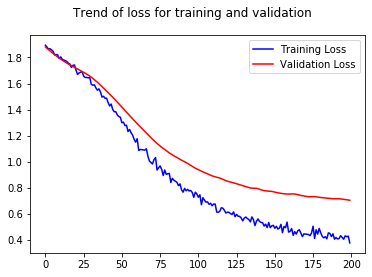

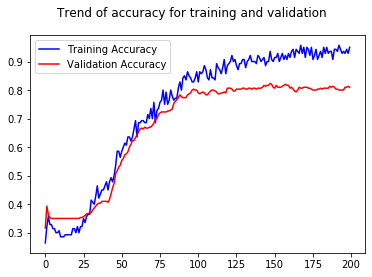

In [0]:
import matplotlib.pyplot as plt

plt.plot(range(args.epochs), all_loss_train, color='b', label='Training Loss')
plt.plot(range(args.epochs), all_loss_val, color='r', label='Validation Loss')
plt.suptitle('Trend of loss for training and validation')
plt.legend()
plt.show()

plt.plot(range(args.epochs), all_acc_train, color='b', label='Training Accuracy')
plt.plot(range(args.epochs), all_acc_val, color='r', label='Validation Accuracy')
plt.suptitle('Trend of accuracy for training and validation')
plt.legend()
plt.show()

